# Statistical and Machine Learning (01.113) - HW3 Question 5
By: Adam Ilyas 1002010

In [1]:
import numpy as np
from mpl_toolkits import mplot3d
from matplotlib import cm
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern

We will use Gaussian process regression to approximate the following function and find its global
maximum (i.e ) $y^{*} \approx 1$ at $( \left(x_{1}^{*}, x_{2}^{*}\right)=(2.25,2.65) )$

In [2]:
# function to predict
def func(x1,x2):
    y = 0.5*np.exp(
        -0.5*((x1+1.25)**2+(x2+1.75)**2)
    )+np.exp(
        -0.5*((x1-2.25)**2+(x2-2.65)**2)
    )
    return y

def calc_true_optimum(func):
    current_max = 0
    x1, x2 = 0, 0
    for x_1 in np.linspace(-10,10, 500):
        for x_2 in np.linspace(-10,10, 500):
            y = func(x_1, x_2)
            if y > current_max:
                current_max = y
                x1 , x2 = x_1, x_2

    print(f"True Global Optimum: {current_max}")
    print(f"Corresponding x1, x2: {x1, x2}")    

Next, we define our “true” and “noisy” functions as follows:

In [3]:
def noisy_func(x1,x2):
    output = func(x1,x2)
    noise = np.random.normal(0,0.1,np.shape(output))
    return output + noise

## Write code for the following acquisition functions: 

- probability of improvement: 
$$A\left(x, f^{*}\right)=P\left(f_{x}>f^{*}\right)=1 - \Phi\left(\gamma_{x}\right)$$
- expected improvement: 
$$\mathbb{E}\left[\max \left\{f_{x}-f^{*}, 0\right\}\right]=\sigma_{x}\left[\gamma_{x} \Phi\left(\gamma_{x}\right)+\phi\left(\gamma_{x}\right)\right]$$ 
- upper confidence bound: 
$$A(x)=\mu_{x}+\kappa \sigma_{x}$$

In [4]:
def probability_of_improvement(mu_x,sigma_x,opt_val):
    gamma = (mu_x - opt_val)/sigma_x
    return 1 - norm.cdf(gamma)
    
def expected_improvement(mu_x,sigma_x,opt_val):
    gamma = (mu_x - opt_val)/sigma_x
    return sigma_x * gamma * norm.cdf(gamma) + sigma_x * norm.pdf(gamma)

def upper_confidence_bound(mu_x,sigma_x,k):
    return mu_x + k * sigma_x

## Define a query function using `scipy.optimize.minimize`  
and the acquisition function of your choice.

In [5]:
def my_acquisition_function(mu_x, sigma_x, k):
#     return expected_improvement(mu_x,sigma_x,opt_val=1)
    return upper_confidence_bound(mu_x,sigma_x,k=1)
def query(opt_val,gp):
    def obj(x):
        #do gaussian process prediction
        mu_x,sigma_x = gp.predict(x.reshape(1,-1),return_std=True)
        
        return -my_acquisition_function(mu_x,sigma_x,opt_val)
    
    x0 = np.random.uniform(-5,5,2)
    res = minimize(obj, x0=x0.reshape(1,-1), bounds=([-5, 5], [-5, 5]))
    return res.x

Use the next few lines of code to visualize the true function.

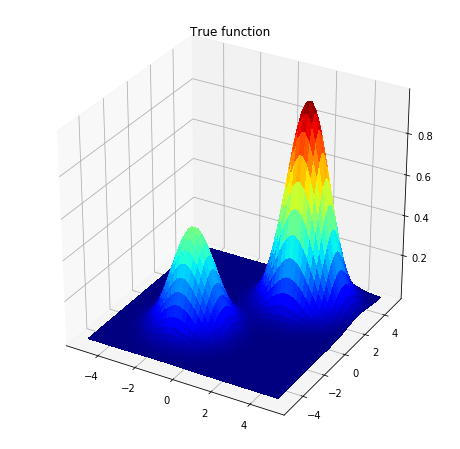

In [6]:
def add_subplot(gp, subplt):
    mu = gp.predict(meshpts, return_std=False)
    ax = fig.add_subplot(2, 5, subplt, projection = '3d')
    ax.plot_surface(meshX, meshY, np. reshape (mu, (50 , 50)) ,
                    rstride=1, cstride =1, cmap=cm. jet,
                    linewidth=0, antialiased=False)

res = 50
lin = np.linspace(-5, 5, res)
meshX, meshY = np.meshgrid(lin, lin)
meshpts = np.vstack((meshX.flatten(), meshY.flatten())).T
true_y = func(meshX, meshY)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(meshX, meshY, true_y, rstride=1, cstride=1,
                cmap=cm.jet, linewidth=0, antialiased=False)
plt.title('True function')
plt.show()

## Initialize 4 random points and evaluate the noisy function at these points:

In [7]:
xi = np.random.uniform(-5,5,(4,2))
yi = noisy_func(xi[:,0], xi[:,1])

## Initialize the Gaussian process regressor with a kernel of your choice:

In [8]:
gp = GaussianProcessRegressor(kernel=RBF(length_scale=1.0) ,
                              n_restarts_optimizer=10)   

Finally, use the following code to perform Bayesian optimization and plot the evolution of the
mean of the Gaussian process over 10 iterations:

Best value:  0.31275336163205103
at  [[-0.75032576 -2.35840128]]
Best value:  0.31275336163205103
at  [[-0.75032576 -2.35840128]]
Best value:  0.31275336163205103
at  [[-0.75032576 -2.35840128]]
Best value:  0.31275336163205103
at  [[-0.75032576 -2.35840128]]
Best value:  0.31275336163205103
at  [[-0.75032576 -2.35840128]]
Best value:  0.31275336163205103
at  [[-0.75032576 -2.35840128]]
Best value:  0.31849226038662243
at  [[1.90363409 1.04364105]]
Best value:  0.31849226038662243
at  [[1.90363409 1.04364105]]
Best value:  0.31849226038662243
at  [[1.90363409 1.04364105]]
Best value:  0.31849226038662243
at  [[1.90363409 1.04364105]]


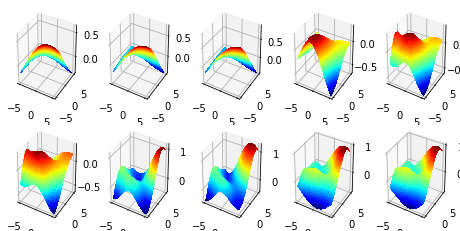

In [9]:
def my_acquisition_function(mu_x, sigma_x, k):
#     return expected_improvement(mu_x,sigma_x,opt_val=1)
#     return upper_confidence_bound(mu_x,sigma_x,k=1)
    return probability_of_improvement(mu_x,sigma_x,opt_val=1)

fig=plt.figure(figsize=plt.figaspect(0.5))

for i in range(10):
    gp.fit(xi,yi)

    #find the current optimal value and its location
    opt_val = max(yi)
    opt_x = xi[np.where(yi == opt_val)]

    print('Best value: ', opt_val)
    print('at ', opt_x)

    next_x = query(opt_val, gp)
    
    # add next_x to the list of data points    
    xi = np.append(xi, [next_x],axis=0)

    next_y = noisy_func(xi[-1][0], xi[-1][1]).reshape(1)

    # add next_y to the list of observations
    yi = np.append(yi,next_y)

    add_subplot(gp, i+1)

plt.show()

In [ ]:
print(f"Final value: {opt_val} at {opt_x[0]} \n")
calc_true_optimum(func)